In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

In [17]:
(x_trn, y_trn), (x_tst, y_tst) = mnist.load_data()

In [18]:
num_features = 28 * 28
num_classes = 10

lr = 0.01
epochs = 1000
batch_size = 32
display_epoch = 10

In [19]:
x_train = (np.array(x_trn, np.float32)).reshape([-1, num_features]) / 255.0
x_test = (np.array(x_tst, np.float32)).reshape([-1, num_features]) / 255.0

y_train = tf.one_hot(y_trn, depth = num_classes)
y_test = tf.one_hot(y_tst, depth = num_classes)

In [20]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [21]:
all_losses = []
all_accuracy = []
all_epochs = []

In [22]:
class Model(object):
    def __init__(self):
        rnd_norm = tf.initializers.RandomNormal()
        self.W_conv1 = tf.Variable(rnd_norm([3, 3, 1, 32]))
        self.b_conv1 = tf.Variable(tf.constant(0.1, shape = [32]))

        self.W_conv2 = tf.Variable(rnd_norm([3, 3, 32, 64]))
        self.b_conv2 = tf.Variable(tf.constant(0.1, shape = [64]))

        self.W_fc1 = tf.Variable(rnd_norm([7 * 7 * 64, 128]))
        self.b_fc1 = tf.Variable(tf.constant(0.1, shape = [128]))

        self.W_fc2 = tf.Variable(rnd_norm([128, 10]))
        self.b_fc2 = tf.Variable(tf.constant(0.1, shape = [10]))
    
    def forward(self, x):
        x_image = tf.reshape(x, [-1, 28, 28, 1])

        self.h_conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(x_image, self.W_conv1, strides=[1, 1, 1, 1], padding='SAME'), self.b_conv1))
        self.h_pool1 = tf.nn.max_pool(self.h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        self.h_conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(self.h_pool1, self.W_conv2, strides=[1, 1, 1, 1], padding='SAME'), self.b_conv2))
        self.h_pool2 = tf.nn.max_pool(self.h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        self.h_flat = tf.reshape(self.h_pool2, [-1, 7 * 7 * 64])
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.h_flat, self.W_fc1), self.b_fc1))

        self.output = tf.nn.softmax(tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2))

        return self.output

In [23]:
model = Model()
optimizer = tf.optimizers.SGD(lr)

c:\Users\vladi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [24]:
def loss(y_pred, y_target):
    cross_entr = tf.reduce_mean(-tf.reduce_sum(y_target * tf.math.log(y_pred)))
    return cross_entr

In [25]:
def accuracy(y_pred, y_target):
    correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_target, 1))
    acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return acc

In [26]:
def optimization(x, y):
    with tf.GradientTape() as gt:
        p_y = model.forward(x)
        cur_loss = loss(p_y, y)
    trainable_variables = [model.W_conv1, model.W_conv2, model.W_fc1, model.W_fc2, model.b_conv1, model.b_conv2, model.b_fc1, model.b_fc2]
    grad = gt.gradient(cur_loss, trainable_variables)
    optimizer.apply_gradients(zip(grad, trainable_variables))
    

In [27]:
def train():
    for epoch, (batch_x, batch_y) in enumerate(train_data.take(epochs), 1):
        optimization(batch_x, batch_y)
        if epoch % display_epoch == 0:
            y_pr = model.forward(batch_x)
            loss_res = loss(y_pr, batch_y)
            acc_res = accuracy(y_pr, batch_y)
            all_losses.append(loss_res)
            all_accuracy.append(acc_res)
            all_epochs.append(epoch)
            print("Epoch {0} Loss {1} Acc {2}".format(epoch, loss_res, acc_res))
    
    return model

In [28]:
model = train()

y_pr_test = model.forward(x_test)
acc_test = accuracy(y_pr_test, y_test)

print("Test acc = {}".format(acc_test))

Epoch 10 Loss 66.61219787597656 Acc 0.25
Epoch 20 Loss 65.4015884399414 Acc 0.3125
Epoch 30 Loss 36.85725402832031 Acc 0.71875
Epoch 40 Loss 38.45773696899414 Acc 0.8125
Epoch 50 Loss 65.7440414428711 Acc 0.34375
Epoch 60 Loss 58.22467041015625 Acc 0.28125
Epoch 70 Loss 21.393726348876953 Acc 0.84375
Epoch 80 Loss 54.184818267822266 Acc 0.46875
Epoch 90 Loss 3.203191041946411 Acc 1.0
Epoch 100 Loss 5.29616117477417 Acc 0.96875
Epoch 110 Loss 11.561603546142578 Acc 0.9375
Epoch 120 Loss 2.667785406112671 Acc 1.0
Epoch 130 Loss 3.3980226516723633 Acc 1.0
Epoch 140 Loss 6.426599979400635 Acc 0.96875
Epoch 150 Loss 3.1517715454101562 Acc 0.9375
Epoch 160 Loss 6.467538833618164 Acc 0.9375
Epoch 170 Loss 0.23714129626750946 Acc 1.0
Epoch 180 Loss 4.256927490234375 Acc 1.0
Epoch 190 Loss 1.2389869689941406 Acc 1.0
Epoch 200 Loss 0.8269758224487305 Acc 1.0
Epoch 210 Loss 0.7904132008552551 Acc 1.0
Epoch 220 Loss 0.9729567766189575 Acc 1.0
Epoch 230 Loss 2.974442958831787 Acc 0.96875
Epoch 240 

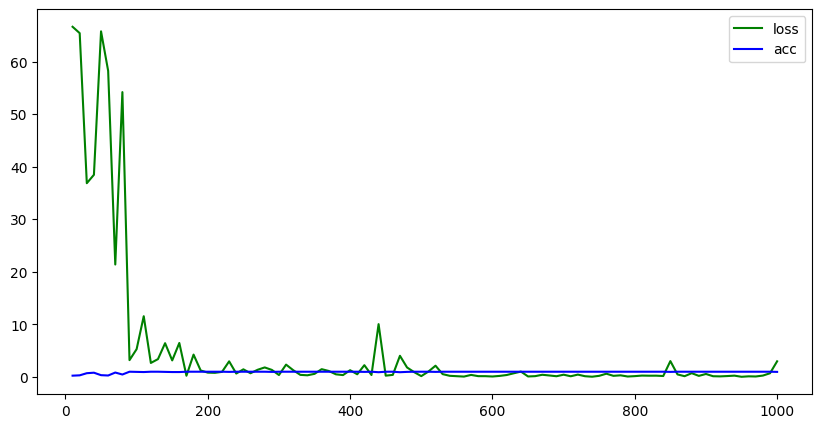

In [29]:
fig, axs = plt.subplots(figsize = (10, 5))
plt.plot(all_epochs, all_losses, 'g-', label = 'loss')
plt.plot(all_epochs, all_accuracy, 'b-', label = 'acc')
plt.legend()
plt.show()